# Ford Stock Data

In [54]:
import pandas as pd
import os
#%pip install pytrends
import pytrends
from pytrends.request import TrendReq
#pip install pageviewapi
import pageviewapi
#%pip install yfinance
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Ford Data Pull

In [64]:
def Big_scraper(kw_list_1, kw_list_2, ticker, start,end):
    
    """
    Description:
    ------------
    
    The function initially grabs historical, indexed, hourly data for when the keyword 
    was searched most as shown on Google Trends' Interest Over Time section.
    It then cleans the data to show daily hits on the keyword in Google news.

    
    input:
    -----
    kw_list_1: List of up to 5 key words that will be scraped from google trends for the dates given.
             Here, the scraping will pull the total posted items in google news that contains
             one of the key words.
    
    kw_list_2: List of wikipedia article titles (unlimited length) that will pull the amount of
            views the article recieved each day. 

    ticker: the ticker abriviation of the desired stock. Must be netered in as an all capitalized string 
    example Apple Inc. woud be "AAPL"
             
    start: the start of the desired timeline you want scrape. Date Must be entered in as "YYYYMMDD"
    
    end: the end of the desired timeline you want scrape. Date Must be entered in as "YYYYMMDD"
             
    return:
    -------
    
    combined: a dataframe containing the sum of the daily keyword hits in google news (key words labeled _x),
    
    data frame cointaing stock info including open, close, high, low prices of the stock,
    as well as the stocks daily trading volume and the amount if there was a split or dividend 
    preformed on the stock that day,
    
    and the sum of how many times key word wikipedia pages were viewed in a day (key words labeled _y)
    """
    
    year_s = int(start[0:4])
    month_s = int(start[4:6])
    day_s = int(start[6:8])
    year_e = int(end[0:4])
    month_e = int(end[4:6])
    day_e = int(end[6:8])
    
    starter = pd.to_datetime(f"'{year_s}-{month_s}-{day_s}'")
    ender = pd.to_datetime(f"'{year_e}-{month_e}-{day_e}'")
    
    
    pytrends = TrendReq(hl='en-US', tz=360, retries=10)
    jeff = pytrends.get_historical_interest(kw_list_1, \
                                 year_start = year_s, month_start = month_s, day_start = day_s, hour_start = 1, \
                                 year_end = year_e, month_end = month_e, day_end = day_e, hour_end = 23, \
                                 cat = 0, geo = '', gprop = 'news', sleep = 60)
    
    jeff = jeff.iloc[:, 0:-1] # eliminates the isPartial Column
    jeff = jeff.reset_index().drop_duplicates(subset = "date") #removing duplicates from the index
    jeff = jeff.groupby(pd.Grouper(key="date", freq="D")).mean() # coverts to the mean of daily scores

    dow = yf.Ticker("^DJI")
    dow_h = dow.history(start=starter, end=ender)
    dow_h = pd.DataFrame(dow_h)
    dow_names = {"Open":"dow_open","Close":"dow_close","Low": "dow_low",
    'High':'dow_high','Volume':'dow_vol'}
    dow_h=dow_h.rename(dow_names, axis=1).drop(["Dividends","Stock Splits"], axis=1)

    nas = yf.Ticker("^IXIC")
    nas_h = nas.history(start=starter, end=ender)
    nas_h = pd.DataFrame(nas_h)
    nas_names = {"Open":"nas_open", "Close":"nas_close", "Low": "nas_low",
    'High':'nas_high','Volume':'nas_vol'}
    nas_h=nas_h.rename(nas_names, axis=1).drop(["Dividends","Stock Splits"], axis=1)

    market = dow_h.merge(nas_h,left_index=True, right_index=True, how="left")
    
    tick = yf.Ticker(ticker)
    hist = tick.history(start=starter, end=ender)
    hist = pd.DataFrame(hist)
    
    combined = jeff.merge(hist, left_index=True, right_index=True, how="left")
    combined = combined.merge(market, left_index=True, right_index=True, how="left")  
    
    d = pd.DataFrame()
    for key_word in kw_list_2:
        geoff = pageviewapi.per_article('en.wikipedia', key_word, start, end,
                                    access='all-access', agent='all-agents', granularity='daily')
        dicty = dict(geoff)
        views = pd.DataFrame(dicty["items"])
        views["timestamp"] = pd.to_datetime((views["timestamp"]), format="%Y%m%d%H")
        views = views.set_index("timestamp")
        page = pd.Series(views["views"])
        d[key_word] = page
        
    combined = combined.merge(d, left_index=True, right_index=True, how="left") 
    
    return combined

In [65]:
Big_scraper(kw_list_1, kw_list_2,"F", "20190101", "20190107")

,Ford,F-150,Ford Bronco_x,Ford Mustang_x,Ford Stock,Open,High,Low,Close,Volume,...,nas_low,nas_close,nas_vol,Ford Motor Company,Ford Mustang_y,Ford F Series,Ford Bronco_y,Lincoln Navigator,Lincoln Aviator,Ford GT
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,13.565217,0.000000,0.000000,1.173913,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5163,3279,15,1372,668,329,1290
2019-01-02,18.791667,0.458333,0.000000,0.500000,0.000000,6.827570,7.271861,6.782234,7.163055,47494400.0,...,6506.879883,6665.939941,2.261800e+09,5648,3804,24,1597,710,341,1466
2019-01-03,22.166667,0.458333,1.000000,1.500000,0.416667,7.226524,7.244658,7.054248,7.054248,39172400.0,...,6457.129883,6463.500000,2.607290e+09,6290,3792,11,1549,678,334,1375
2019-01-04,18.333333,0.000000,0.458333,0.750000,1.125000,7.172122,7.362532,7.117719,7.326263,43039800.0,...,6554.240234,6738.859863,2.579550e+09,6227,3800,15,1387,679,303,1390
2019-01-05,23.291667,0.000000,0.625000,1.750000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6131,3872,22,3319,761,339,1490
2019-01-06,16.416667,0.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6778,3910,15,1587,734,445,1470
2019-01-07,20.708333,0.000000,1.291667,0.708333,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6110,3760,25,1507,727,444,1277


In [66]:
kw_list_1 = ["Ford", "F-150", "Ford Bronco", "Ford Mustang", "Ford Stock"]
kw_list_2 = ["Ford Motor Company", "Ford Mustang", "Ford F Series", "Ford Bronco", "Lincoln Navigator", "Lincoln Aviator", "Ford GT"]

In [68]:
Ford_19 = Big_scraper(kw_list_1, kw_list_2,"F", "20190101", "20191231")
Ford_19.to_csv("2019_Ford_Data.csv")
Ford_20 = Big_scraper(kw_list_1, kw_list_2,"F", "20200101", "20201231")
Ford_20.to_csv("2020_Ford_Data.csv")
Ford_21 = Big_scraper(kw_list_1, kw_list_2,"F", "20210101", "20211231")
Ford_21.to_csv("2021_Ford_Data.csv")
Ford_22 = Big_scraper(kw_list_1, kw_list_2,"F", "20220101", "20220331")
Ford_22.to_csv("2022_Ford_Data.csv")

In [ ]:
ford = pd.concat([Ford_19, Ford_20, Ford_21, Ford_22])
ford.head()

In [13]:
ford.to_csv("Ford_full_data.csv")

Raw data saved, now we will read it back in to start cleaning it.

## Data Clean and Shape

In [73]:
Ford = pd.read_csv("Ford_full_data.csv")
Ford.head()

,date,Ford,F-150,Ford Bronco_x,Ford Mustang_x,Ford Stock,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ford Motor Company,Ford Mustang_y,Ford F Series,Ford Bronco_y,Lincoln Navigator,Lincoln Aviator,Ford GT,Date,dow_open,dow_high,dow_low,dow_close,dow_vol,nas_open,nas_high,nas_low,nas_close,nas_vol
0,2019-01-01,14.043478,0.0,0.000000,1.217391,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5163,3279,15.0,1372,668,329,1290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,19.416667,0.5,0.000000,0.541667,0.000000,6.827570,7.271861,6.782234,7.163055,47494400.0,0.0,0.0,5648,3804,24.0,1597,710,341,1466,2019-01-02,23058.609375,23413.470703,22928.589844,23346.240234,321570000.0,6506.910156,6693.709961,6506.879883,6665.939941,2.261800e+09
2,2019-01-03,23.041667,0.5,1.083333,1.500000,0.458333,7.226524,7.244659,7.054249,7.054249,39172400.0,0.0,0.0,6290,3792,11.0,1549,678,334,1375,2019-01-03,23176.390625,23176.390625,22638.410156,22686.220703,424240000.0,6584.770020,6600.209961,6457.129883,6463.500000,2.607290e+09
3,2019-01-04,19.208333,0.0,0.500000,0.791667,1.208333,7.172122,7.362532,7.117719,7.326263,43039800.0,0.0,0.0,6227,3800,15.0,1387,679,303,1390,2019-01-04,22894.919922,23518.640625,22894.919922,23433.160156,396020000.0,6567.140137,6760.689941,6554.240234,6738.859863,2.579550e+09
4,2019-01-05,24.000000,0.0,0.666667,1.875000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6131,3872,22.0,3319,761,339,1490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
#converting the date column back to datetime 
Ford.date = pd.to_datetime(Ford.date)
Ford['Ford F Series'] = Ford['Ford F Series'].fillna(0)

In [75]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# create dateframe 2019-01-01 to 2022-03-31 which excludes weekends and holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
dates = pd.date_range(start='2019-01-01', end='2022-03-31', freq=us_bd)
dates = pd.DataFrame(dates)
dates = dates.rename(columns={0: "date"})

# Merge on new date range to remove weekends and holidays in netflix dataset
Ford = dates.merge(Ford, on="date", how="left")
Ford = Ford.set_index("date")
Ford.head()

,Ford,F-150,Ford Bronco_x,Ford Mustang_x,Ford Stock,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ford Motor Company,Ford Mustang_y,Ford F Series,Ford Bronco_y,Lincoln Navigator,Lincoln Aviator,Ford GT,Date,dow_open,dow_high,dow_low,dow_close,dow_vol,nas_open,nas_high,nas_low,nas_close,nas_vol
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,19.416667,0.5,0.000000,0.541667,0.000000,6.827570,7.271861,6.782234,7.163055,47494400.0,0.0,0.0,5648,3804,24.0,1597,710,341,1466,2019-01-02,23058.609375,23413.470703,22928.589844,23346.240234,321570000.0,6506.910156,6693.709961,6506.879883,6665.939941,2.261800e+09
2019-01-03,23.041667,0.5,1.083333,1.500000,0.458333,7.226524,7.244659,7.054249,7.054249,39172400.0,0.0,0.0,6290,3792,11.0,1549,678,334,1375,2019-01-03,23176.390625,23176.390625,22638.410156,22686.220703,424240000.0,6584.770020,6600.209961,6457.129883,6463.500000,2.607290e+09
2019-01-04,19.208333,0.0,0.500000,0.791667,1.208333,7.172122,7.362532,7.117719,7.326263,43039800.0,0.0,0.0,6227,3800,15.0,1387,679,303,1390,2019-01-04,22894.919922,23518.640625,22894.919922,23433.160156,396020000.0,6567.140137,6760.689941,6554.240234,6738.859863,2.579550e+09
2019-01-07,21.708333,0.0,1.333333,0.750000,0.000000,7.353465,7.589211,7.280928,7.516674,40729400.0,0.0,0.0,6110,3760,25.0,1507,727,444,1277,2019-01-07,23474.259766,23687.740234,23301.589844,23531.349609,334200000.0,6757.529785,6855.600098,6741.399902,6823.470215,2.507550e+09
2019-01-08,20.916667,0.0,0.625000,1.125000,0.416667,7.634546,7.743352,7.571077,7.589211,45644000.0,0.0,0.0,6482,3583,11.0,1530,721,403,1271,2019-01-08,23680.320312,23864.650391,23581.449219,23787.449219,317420000.0,6893.439941,6909.580078,6795.859863,6897.000000,2.380290e+09


In [76]:
# creating base varibles to be used in variable creator functions
Ford["Wiki_total"] = (Ford["Ford Motor Company"] + 
    Ford["Ford Mustang_y"] + Ford["Ford F Series"] + 
    Ford["Ford Bronco_y"] + Ford["Lincoln Navigator"] + 
    Ford["Lincoln Aviator"] + Ford["Ford GT"])

Ford["Google_total"] = (Ford["Ford"] +
    Ford["F-150"] + Ford["Ford Bronco_x"] +
    Ford["Ford Mustang_x"] + Ford["Ford Stock"])

Ford["Stock_total"] = Ford["Close"]
Ford["Nas_total"] = Ford["nas_close"]
Ford["Dow_total"] = Ford["dow_close"]

In [77]:
def variables_creator(df, variable_list, w=7):
    
    '''
    descrition:
    -----------
    takes dataframe and returns new varibles based on recommmended calcualtions, 
    it should be done seporately with internet based and stock based dataframes

    Note: When using for aggreated varaibles, for example Wiki_total, the sum of all the wiki pages daily page view counts, 
    you MUST calculate Wiki_total in the dataframe seperately BEFORE this function can be used. 

    For example if you had wiki page counts for Ford Bronco and Ford Ranger, Wiki_total would equal Ford Bronco + Ford ranger counts, 
    AGAIN Wiki_total must be calculated in the desired dateframe before using this function 

    input:
    ------
    df: dataframe containing the google trends, yahoo finance, and or wikipedia page count data

    variable_list: list of strings to be added to the equations to calculate the new varaibles. 
    ex. insertting the string "Wiki" will add to df[f"{}_total"] to become "Wiki_total"

    w: the window length for one period shift. Default is 7 providing 7 day moving averages for wiki and google data, 
        FOR STOCK DATA THIS WILL NEED TO BE CHANGED TO 5.

    output:
    -------
    df: the same dataframe as was inputted but now containing variables for 
    Momemtum, Disparity, Moving Average, Exponential Moving Aerage, Rator Change, and RSI index score.
    Also containg are moving variables, which are boolean with 1 indicating an increase in the above variables
    '''   
    
    for i in variable_list:
        # Momentum_1
        df[f"{i}_Moment_1"] =  (df[f"{i}_total"] / df[f"{i}_total"].shift(w)) * 100
        # Momentum_2
        df[f"{i}_Moment_2"] =  (df[f"{i}_total"] - df[f"{i}_total"].shift(w)) * 100
        # Momentum_1_s three day shift (instead of w)
        df[f"{i}_Moment_1_s"] =  (df[f"{i}_total"] / df[f"{i}_total"].shift(3)) * 100
        # Momentum_2_s
        df[f"{i}_Moment_2_s"] =  (df[f"{i}_total"] - df[f"{i}_total"].shift(3)) * 100
        # Moving average
        df[f"{i}_MAvg"] = df[f"{i}_total"].rolling(f"{w}d").mean()
        # Moving average 3 day
        df[f"{i}_MAvg_s"] = df[f"{i}_total"].rolling("3d").mean()
        # Disparity
        df[f"{i}_Disparity"] = (df[f"{i}_total"]/df[f"{i}_MAvg"]) * 100
        # Disparity 3 day
        df[f"{i}_Disparity_s"] = (df[f"{i}_total"]/df[f"{i}_MAvg_s"]) * 100
        # Rate of Change Normal Way
        df[f"{i}_ROC"] = (df[f"{i}_total"]-df[f"{i}_total"].shift(w))/(df[f"{i}_total"].shift(w)) *100
        df[f"{i}_ROC_s"] = (df[f"{i}_total"]-df[f"{i}_total"].shift(3))/(df[f"{i}_total"].shift(3)) *100
        #Rate of Change Paper Way (doesn't make sense but just in case)
        df[f'{i}_Rocp'] = (df[f"{i}_total"]/df[f"{i}_Moment_2"]) *100
        # Exponential Moving Average
        df[f"{i}_EMA"] = (df[f"{i}_total"]-df[f"{i}_MAvg"].shift(1))*(2/(w+1))+df[f"{i}_MAvg"].shift(1)

        # calculating the Relative Strength Index, based on 14 day window
        df[f"{i}_diff"] = df[f"{i}_total"].diff(1)
        df[f"{i}_gain"] = df[f"{i}_diff"].clip(lower=0).round(2) #keeps all values above or below a given threshold, lower=lower bound
        df[f"{i}_loss"] = df[f"{i}_diff"].clip(upper=0).round(2)
        df[f'{i}_avg_gain'] = df[f'{i}_gain'].rolling(14).mean()
        df[f'{i}_avg_loss'] = df[f'{i}_loss'].rolling(14).mean()
        df[f'{i}_rs'] = df[f'{i}_avg_gain'] / df[f'{i}_avg_loss']
        df[f'{i}_RSI'] = 100 - (100 / (1.0 + df[f'{i}_rs']))

        # Calculatiing the Move Variables 
        df[f"{i}_Move"] = df[f"{i}_total"] > df[f"{i}_total"].shift(1) 
        df[f"{i}_Move"] = df[f"{i}_Move"].replace({True:1,False: 0})
    
      
        df[f"{i}_MAvg_Move"] = df[f"{i}_MAvg"] > df[f"{i}_MAvg"].shift(1) 
        df[f"{i}_MAvg_Move"] = df[f"{i}_MAvg_Move"].replace({True:1,False: 0})
        df[f"{i}_MAvg_s_Move"] = df[f"{i}_MAvg_s"] > df[f"{i}_MAvg_s"].shift(1) 
        df[f"{i}_MAvg_s_Move"] = df[f"{i}_MAvg_s_Move"].replace({True:1,False: 0})

        df[f"{i}_EMA_Move"] = df[f"{i}_EMA"] > df[f"{i}_EMA"].shift(1) 
        df[f"{i}_EMA_Move"] = df[f"{i}_EMA_Move"].replace({True:1,False: 0})

        df[f"{i}_Disparity_Move"] = df[f"{i}_Disparity"] > df[f"{i}_Disparity"].shift(1) 
        df[f"{i}_Disparity_Move"] = df[f"{i}_Disparity_Move"].replace({True:1,False: 0})
        df[f"{i}_Disparity_s_Move"] = df[f"{i}_Disparity_s"] > df[f"{i}_Disparity_s"].shift(1) 
        df[f"{i}_Disparity_s_Move"] = df[f"{i}_Disparity_s_Move"].replace({True:1,False: 0})

        df[f"{i}_RSI_Move"] = df[f"{i}_RSI"] > df[f"{i}_RSI"].shift(1) 
        df[f"{i}_RSI_Move"] = df[f"{i}_RSI_Move"].replace({True:1,False: 0})
        
    return df

In [78]:
Ford = variables_creator(Ford, ["Wiki","Google", "Stock", "Nas", "Dow"], 5)

/var/folders/jx/v484103954dd6vtd4swk8hd40000gn/T/ipykernel_8165/3769982097.py:55: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{i}_EMA"] = (df[f"{i}_total"]-df[f"{i}_MAvg"].shift(1))*(2/(w+1))+df[f"{i}_MAvg"].shift(1)
/var/folders/jx/v484103954dd6vtd4swk8hd40000gn/T/ipykernel_8165/3769982097.py:58: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{i}_diff"] = df[f"{i}_total"].diff(1)
/var/folders/jx/v484103954dd6vtd4swk8hd40000gn/T/ipykernel_8165/3769982097.py:59: PerformanceWarning: DataFrame is highly fragmented.  Th

In [79]:
def target_creator(df):
    '''
    description: creates the differnt types of target variables based on tomorrow minus today,
    '''
        
    # target 1, Open(t+1) - Close(t)
    df["target_1"] = (df["Open"].shift(-1) - df["Close"]) > 0
    df["target_1"] = df["target_1"].replace({True:1,False: 0})
    # target 2
    df["target_2"] = (df["Open"].shift(-1) - df["Open"]) > 0
    df["target_2"] = df["target_2"].replace({True:1,False: 0})
    # target 3
    df["target_3"] = (df["Close"].shift(-1) - df["Close"]) > 0
    df["target_3"] = df["target_3"].replace({True:1,False: 0})
    # target 4
    df["target_4"] = (df["Close"].shift(-1) - df["Open"]) > 0
    df["target_4"] = df["target_4"].replace({True:1,False: 0})
    # target 5
    df["target_5"] = (df["Volume"].shift(-1) - df["Volume"]) > 0
    df["target_5"] = df["target_5"].replace({True:1,False: 0})
 
    return df

In [80]:
Ford = target_creator(Ford)

/var/folders/jx/v484103954dd6vtd4swk8hd40000gn/T/ipykernel_8165/27534496.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["target_1"] = (df["Open"].shift(-1) - df["Close"]) > 0
/var/folders/jx/v484103954dd6vtd4swk8hd40000gn/T/ipykernel_8165/27534496.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["target_2"] = (df["Open"].shift(-1) - df["Open"]) > 0
/var/folders/jx/v484103954dd6vtd4swk8hd40000gn/T/ipykernel_8165/27534496.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of cal

In [81]:
pd.set_option('display.max_columns', None)
Ford.head(15)

,Ford,F-150,Ford Bronco_x,Ford Mustang_x,Ford Stock,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ford Motor Company,Ford Mustang_y,Ford F Series,Ford Bronco_y,Lincoln Navigator,Lincoln Aviator,Ford GT,Date,dow_open,dow_high,dow_low,dow_close,dow_vol,nas_open,nas_high,nas_low,nas_close,nas_vol,Wiki_total,Google_total,Stock_total,Nas_total,Dow_total,Wiki_Moment_1,Wiki_Moment_2,Wiki_Moment_1_s,Wiki_Moment_2_s,Wiki_MAvg,Wiki_MAvg_s,Wiki_Disparity,Wiki_Disparity_s,Wiki_ROC,Wiki_ROC_s,Wiki_Rocp,Wiki_EMA,Wiki_diff,Wiki_gain,Wiki_loss,Wiki_avg_gain,Wiki_avg_loss,Wiki_rs,Wiki_RSI,Wiki_Move,Wiki_MAvg_Move,Wiki_MAvg_s_Move,Wiki_EMA_Move,Wiki_Disparity_Move,Wiki_Disparity_s_Move,Wiki_RSI_Move,Google_Moment_1,Google_Moment_2,Google_Moment_1_s,Google_Moment_2_s,Google_MAvg,Google_MAvg_s,Google_Disparity,Google_Disparity_s,Google_ROC,Google_ROC_s,Google_Rocp,Google_EMA,Google_diff,Google_gain,Google_loss,Google_avg_gain,Google_avg_loss,Google_rs,Google_RSI,Google_Move,Google_MAvg_Move,Google_MAvg_s_Move,Google_EMA_Move,Google_Disparity_Move,Google_Disparity_s_Move,Google_RSI_Move,Stock_Moment_1,Stock_Moment_2,Stock_Moment_1_s,Stock_Moment_2_s,Stock_MAvg,Stock_MAvg_s,Stock_Disparity,Stock_Disparity_s,Stock_ROC,Stock_ROC_s,Stock_Rocp,Stock_EMA,Stock_diff,Stock_gain,Stock_loss,Stock_avg_gain,Stock_avg_loss,Stock_rs,Stock_RSI,Stock_Move,Stock_MAvg_Move,Stock_MAvg_s_Move,Stock_EMA_Move,Stock_Disparity_Move,Stock_Disparity_s_Move,Stock_RSI_Move,Nas_Moment_1,Nas_Moment_2,Nas_Moment_1_s,Nas_Moment_2_s,Nas_MAvg,Nas_MAvg_s,Nas_Disparity,Nas_Disparity_s,Nas_ROC,Nas_ROC_s,Nas_Rocp,Nas_EMA,Nas_diff,Nas_gain,Nas_loss,Nas_avg_gain,Nas_avg_loss,Nas_rs,Nas_RSI,Nas_Move,Nas_MAvg_Move,Nas_MAvg_s_Move,Nas_EMA_Move,Nas_Disparity_Move,Nas_Disparity_s_Move,Nas_RSI_Move,Dow_Moment_1,Dow_Moment_2,Dow_Moment_1_s,Dow_Moment_2_s,Dow_MAvg,Dow_MAvg_s,Dow_Disparity,Dow_Disparity_s,Dow_ROC,Dow_ROC_s,Dow_Rocp,Dow_EMA,Dow_diff,Dow_gain,Dow_loss,Dow_avg_gain,Dow_avg_loss,Dow_rs,Dow_RSI,Dow_Move,Dow_MAvg_Move,Dow_MAvg_s_Move,Dow_EMA_Move,Dow_Disparity_Move,Dow_Disparity_s_Move,Dow_RSI_Move,target_1,target_2,target_3,target_4,target_5
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,19.416667,0.500000,0.000000,0.541667,0.000000,6.827570,7.271861,6.782234,7.163055,47494400.0,0.0,0.0,5648,3804,24.0,1597,710,341,1466,2019-01-02,23058.609375,23413.470703,22928.589844,23346.240234,321570000.0,6506.910156,6693.709961,6506.879883,6665.939941,2.261800e+09,13590.0,20.458333,7.163055,6665.939941,23346.240234,NaN,NaN,NaN,NaN,13590.000000,13590.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,20.458333,20.458333,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,7.163055,7.163055,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,6665.939941,6665.939941,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,23346.240234,23346.240234,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,1,0,1,0
2019-01-03,23.041667,0.500000,1.083333,1.500000,0.458333,7.226524,7.244659,7.054249,7.054249,39172400.0,0.0,0.0,6290,3792,11.0,1549,678,334,1375,2019-01-03,23176.390625,23176.390625,22638.410156,22686.220703,424240000.0,6584.770020,6600.209961,6457.129883,6463.500000,2.607290e+09,14029.0,26.583333,7.054249,6463.500000,22686.220703,NaN,NaN,NaN,NaN,13809.500000,13809.500000,101.589485,101.589485,NaN,NaN,NaN,13736.333333,439.0,439.0,0.0,NaN,NaN,NaN,NaN,1,1,1,0,1,1,0,NaN,NaN,NaN,NaN,23.520833,23.520833,113.020372,113.020372,NaN,NaN,NaN,22.500000,6.125000,6.12,0.00,NaN,NaN,NaN,NaN,1,1,1,0,1,1,0,NaN,NaN,NaN,NaN,7.108652,7.108652,99.234692,99.234692,NaN,NaN,NaN,7.126786,-0.108806,0.00,-0.11,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,6564.719971,6564.719971

In [82]:
Ford = Ford.drop("Date", axis=1)

In [83]:
Ford.iloc[15:].columns[Ford.isna().any()].tolist()

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Dividends',
 'Stock Splits',
 'dow_open',
 'dow_high',
 'dow_low',
 'dow_close',
 'dow_vol',
 'nas_open',
 'nas_high',
 'nas_low',
 'nas_close',
 'nas_vol',
 'Stock_total',
 'Nas_total',
 'Dow_total',
 'Wiki_Moment_1',
 'Wiki_Moment_2',
 'Wiki_Moment_1_s',
 'Wiki_Moment_2_s',
 'Wiki_ROC',
 'Wiki_ROC_s',
 'Wiki_Rocp',
 'Wiki_EMA',
 'Wiki_diff',
 'Wiki_gain',
 'Wiki_loss',
 'Wiki_avg_gain',
 'Wiki_avg_loss',
 'Wiki_rs',
 'Wiki_RSI',
 'Google_Moment_1',
 'Google_Moment_2',
 'Google_Moment_1_s',
 'Google_Moment_2_s',
 'Google_ROC',
 'Google_ROC_s',
 'Google_Rocp',
 'Google_EMA',
 'Google_diff',
 'Google_gain',
 'Google_loss',
 'Google_avg_gain',
 'Google_avg_loss',
 'Google_rs',
 'Google_RSI',
 'Stock_Moment_1',
 'Stock_Moment_2',
 'Stock_Moment_1_s',
 'Stock_Moment_2_s',
 'Stock_Disparity',
 'Stock_Disparity_s',
 'Stock_ROC',
 'Stock_ROC_s',
 'Stock_Rocp',
 'Stock_EMA',
 'Stock_diff',
 'Stock_gain',
 'Stock_loss',
 'Stock_avg_gain',
 'Stock

In [84]:
Ford[Ford.isna().any(axis=1)].tail(10)

,Ford,F-150,Ford Bronco_x,Ford Mustang_x,Ford Stock,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ford Motor Company,Ford Mustang_y,Ford F Series,Ford Bronco_y,Lincoln Navigator,Lincoln Aviator,Ford GT,dow_open,dow_high,dow_low,dow_close,dow_vol,nas_open,nas_high,nas_low,nas_close,nas_vol,Wiki_total,Google_total,Stock_total,Nas_total,Dow_total,Wiki_Moment_1,Wiki_Moment_2,Wiki_Moment_1_s,Wiki_Moment_2_s,Wiki_MAvg,Wiki_MAvg_s,Wiki_Disparity,Wiki_Disparity_s,Wiki_ROC,Wiki_ROC_s,Wiki_Rocp,Wiki_EMA,Wiki_diff,Wiki_gain,Wiki_loss,Wiki_avg_gain,Wiki_avg_loss,Wiki_rs,Wiki_RSI,Wiki_Move,Wiki_MAvg_Move,Wiki_MAvg_s_Move,Wiki_EMA_Move,Wiki_Disparity_Move,Wiki_Disparity_s_Move,Wiki_RSI_Move,Google_Moment_1,Google_Moment_2,Google_Moment_1_s,Google_Moment_2_s,Google_MAvg,Google_MAvg_s,Google_Disparity,Google_Disparity_s,Google_ROC,Google_ROC_s,Google_Rocp,Google_EMA,Google_diff,Google_gain,Google_loss,Google_avg_gain,Google_avg_loss,Google_rs,Google_RSI,Google_Move,Google_MAvg_Move,Google_MAvg_s_Move,Google_EMA_Move,Google_Disparity_Move,Google_Disparity_s_Move,Google_RSI_Move,Stock_Moment_1,Stock_Moment_2,Stock_Moment_1_s,Stock_Moment_2_s,Stock_MAvg,Stock_MAvg_s,Stock_Disparity,Stock_Disparity_s,Stock_ROC,Stock_ROC_s,Stock_Rocp,Stock_EMA,Stock_diff,Stock_gain,Stock_loss,Stock_avg_gain,Stock_avg_loss,Stock_rs,Stock_RSI,Stock_Move,Stock_MAvg_Move,Stock_MAvg_s_Move,Stock_EMA_Move,Stock_Disparity_Move,Stock_Disparity_s_Move,Stock_RSI_Move,Nas_Moment_1,Nas_Moment_2,Nas_Moment_1_s,Nas_Moment_2_s,Nas_MAvg,Nas_MAvg_s,Nas_Disparity,Nas_Disparity_s,Nas_ROC,Nas_ROC_s,Nas_Rocp,Nas_EMA,Nas_diff,Nas_gain,Nas_loss,Nas_avg_gain,Nas_avg_loss,Nas_rs,Nas_RSI,Nas_Move,Nas_MAvg_Move,Nas_MAvg_s_Move,Nas_EMA_Move,Nas_Disparity_Move,Nas_Disparity_s_Move,Nas_RSI_Move,Dow_Moment_1,Dow_Moment_2,Dow_Moment_1_s,Dow_Moment_2_s,Dow_MAvg,Dow_MAvg_s,Dow_Disparity,Dow_Disparity_s,Dow_ROC,Dow_ROC_s,Dow_Rocp,Dow_EMA,Dow_diff,Dow_gain,Dow_loss,Dow_avg_gain,Dow_avg_loss,Dow_rs,Dow_RSI,Dow_Move,Dow_MAvg_Move,Dow_MAvg_s_Move,Dow_EMA_Move,Dow_Disparity_Move,Dow_Disparity_s_Move,Dow_RSI_Move,target_1,target_2,target_3,target_4,target_5
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-12,12.291667,0.000000,0.000000,0.375000,0.791667,12.291974,12.341142,12.114969,12.173971,40422800.0,0.0,0.0,4775,3485,10.0,2532,628,633,1441,33775.058594,33786.191406,33665.539062,33745.398438,327370000.0,13854.440430,13877.000000,13783.950195,13850.000000,4.230160e+09,13504.0,13.458333,12.173971,13850.000000,33745.398438,93.862515,-88300.0,99.535638,-6300.0,13538.666667,13504.000000,99.743943,100.000000,-6.137485,-0.464362,-15.293318,13668.533333,111.0,111.0,0.0,128.428571,-163.785714,-0.784126,-363.232323,1,0,0,0,1,1,0,83.033419,-275.000000,41.357234,-1908.333333,17.569444,13.458333,76.600791,100.000000,-16.966581,-58.642766,-4.893939,18.513889,-2.375000,0.00,-2.38,2.853571,-3.420000,-0.834378,-503.783102,0,0,0,0,1,1,0,97.480324,-31.467342,97.250596,-34.417439,12.259195,12.173971,99.304814,100.000000,-2.519676,-2.749404,-38.687637,12.366709,-0.127836,0.00,-0.13,NaN,NaN,NaN,NaN,0,0,0,0,1,1,0,101.053659,14441.015625,101.177311,16116.015625,13859.833333,13850.000000,99.929052,100.000000,1.053659,1.177311,95.907382,13792.974609,-50.190430,0.00,-50.19,NaN,NaN,NaN,NaN,0,1,1,1,0,0,0,100.650836,21820.703125,100.894380,29913.671875,33683.190104,33745.398438,100.184687,100.000000,0.650836,0.894380,154.648538,33609.514583,-55.203125,0.00,-55.20,NaN,NaN,NaN,NaN,0,1,1,1,0,0,0,1,0,0,0,1
2021-04-13,19.916667,0.000000,0.541667,0.541667,0.000000,12.183805,12.242806,11.898631,11.996966,51556000.0,0.0,0.0,5327,3545,5.0,2553,667,583,1249,33721.160156,33741.640625,33545.839844,33677.269531,324480000.0,13902.450195,14011.509766,13902.450195,13996.099609,4.200290e+09,13929.0,21.000000,11.996966,13996.099609,33677.269531,101.760666,24100.0,101.530724,21000.0,13608.666667,13716.500000,102.35

In [85]:
Ford['Ford F Series'] = Ford['Ford F Series'].fillna(0)


In [86]:
Ford.head()

,Ford,F-150,Ford Bronco_x,Ford Mustang_x,Ford Stock,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ford Motor Company,Ford Mustang_y,Ford F Series,Ford Bronco_y,Lincoln Navigator,Lincoln Aviator,Ford GT,dow_open,dow_high,dow_low,dow_close,dow_vol,nas_open,nas_high,nas_low,nas_close,nas_vol,Wiki_total,Google_total,Stock_total,Nas_total,Dow_total,Wiki_Moment_1,Wiki_Moment_2,Wiki_Moment_1_s,Wiki_Moment_2_s,Wiki_MAvg,Wiki_MAvg_s,Wiki_Disparity,Wiki_Disparity_s,Wiki_ROC,Wiki_ROC_s,Wiki_Rocp,Wiki_EMA,Wiki_diff,Wiki_gain,Wiki_loss,Wiki_avg_gain,Wiki_avg_loss,Wiki_rs,Wiki_RSI,Wiki_Move,Wiki_MAvg_Move,Wiki_MAvg_s_Move,Wiki_EMA_Move,Wiki_Disparity_Move,Wiki_Disparity_s_Move,Wiki_RSI_Move,Google_Moment_1,Google_Moment_2,Google_Moment_1_s,Google_Moment_2_s,Google_MAvg,Google_MAvg_s,Google_Disparity,Google_Disparity_s,Google_ROC,Google_ROC_s,Google_Rocp,Google_EMA,Google_diff,Google_gain,Google_loss,Google_avg_gain,Google_avg_loss,Google_rs,Google_RSI,Google_Move,Google_MAvg_Move,Google_MAvg_s_Move,Google_EMA_Move,Google_Disparity_Move,Google_Disparity_s_Move,Google_RSI_Move,Stock_Moment_1,Stock_Moment_2,Stock_Moment_1_s,Stock_Moment_2_s,Stock_MAvg,Stock_MAvg_s,Stock_Disparity,Stock_Disparity_s,Stock_ROC,Stock_ROC_s,Stock_Rocp,Stock_EMA,Stock_diff,Stock_gain,Stock_loss,Stock_avg_gain,Stock_avg_loss,Stock_rs,Stock_RSI,Stock_Move,Stock_MAvg_Move,Stock_MAvg_s_Move,Stock_EMA_Move,Stock_Disparity_Move,Stock_Disparity_s_Move,Stock_RSI_Move,Nas_Moment_1,Nas_Moment_2,Nas_Moment_1_s,Nas_Moment_2_s,Nas_MAvg,Nas_MAvg_s,Nas_Disparity,Nas_Disparity_s,Nas_ROC,Nas_ROC_s,Nas_Rocp,Nas_EMA,Nas_diff,Nas_gain,Nas_loss,Nas_avg_gain,Nas_avg_loss,Nas_rs,Nas_RSI,Nas_Move,Nas_MAvg_Move,Nas_MAvg_s_Move,Nas_EMA_Move,Nas_Disparity_Move,Nas_Disparity_s_Move,Nas_RSI_Move,Dow_Moment_1,Dow_Moment_2,Dow_Moment_1_s,Dow_Moment_2_s,Dow_MAvg,Dow_MAvg_s,Dow_Disparity,Dow_Disparity_s,Dow_ROC,Dow_ROC_s,Dow_Rocp,Dow_EMA,Dow_diff,Dow_gain,Dow_loss,Dow_avg_gain,Dow_avg_loss,Dow_rs,Dow_RSI,Dow_Move,Dow_MAvg_Move,Dow_MAvg_s_Move,Dow_EMA_Move,Dow_Disparity_Move,Dow_Disparity_s_Move,Dow_RSI_Move,target_1,target_2,target_3,target_4,target_5
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,19.416667,0.5,0.000000,0.541667,0.000000,6.827570,7.271861,6.782234,7.163055,47494400.0,0.0,0.0,5648,3804,24.0,1597,710,341,1466,23058.609375,23413.470703,22928.589844,23346.240234,321570000.0,6506.910156,6693.709961,6506.879883,6665.939941,2.261800e+09,13590.0,20.458333,7.163055,6665.939941,23346.240234,NaN,NaN,NaN,NaN,13590.000000,13590.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,20.458333,20.458333,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,7.163055,7.163055,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,6665.939941,6665.939941,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,23346.240234,23346.240234,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,1,0,1,0
2019-01-03,23.041667,0.5,1.083333,1.500000,0.458333,7.226524,7.244659,7.054249,7.054249,39172400.0,0.0,0.0,6290,3792,11.0,1549,678,334,1375,23176.390625,23176.390625,22638.410156,22686.220703,424240000.0,6584.770020,6600.209961,6457.129883,6463.500000,2.607290e+09,14029.0,26.583333,7.054249,6463.500000,22686.220703,NaN,NaN,NaN,NaN,13809.500000,13809.500000,101.589485,101.589485,NaN,NaN,NaN,13736.333333,439.0,439.0,0.0,NaN,NaN,NaN,NaN,1,1,1,0,1,1,0,NaN,NaN,NaN,NaN,23.520833,23.520833,113.020372,113.020372,NaN,NaN,NaN,22.500000,6.125000,6.12,0.00,NaN,NaN,NaN,NaN,1,1,1,0,1,1,0,NaN,NaN,NaN,NaN,7.108652,7.108652,99.234692,99.234692,NaN,NaN,NaN,7.126786,-0.108806,0.00,-0.11,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,6564.719971,6564.719971,98.458122,98.458122,NaN,NaN,NaN,6598.

In [87]:
Ford.to_csv("Ford_Cleaned_Date.csv")

## Initial Variable Slection 

<AxesSubplot:>

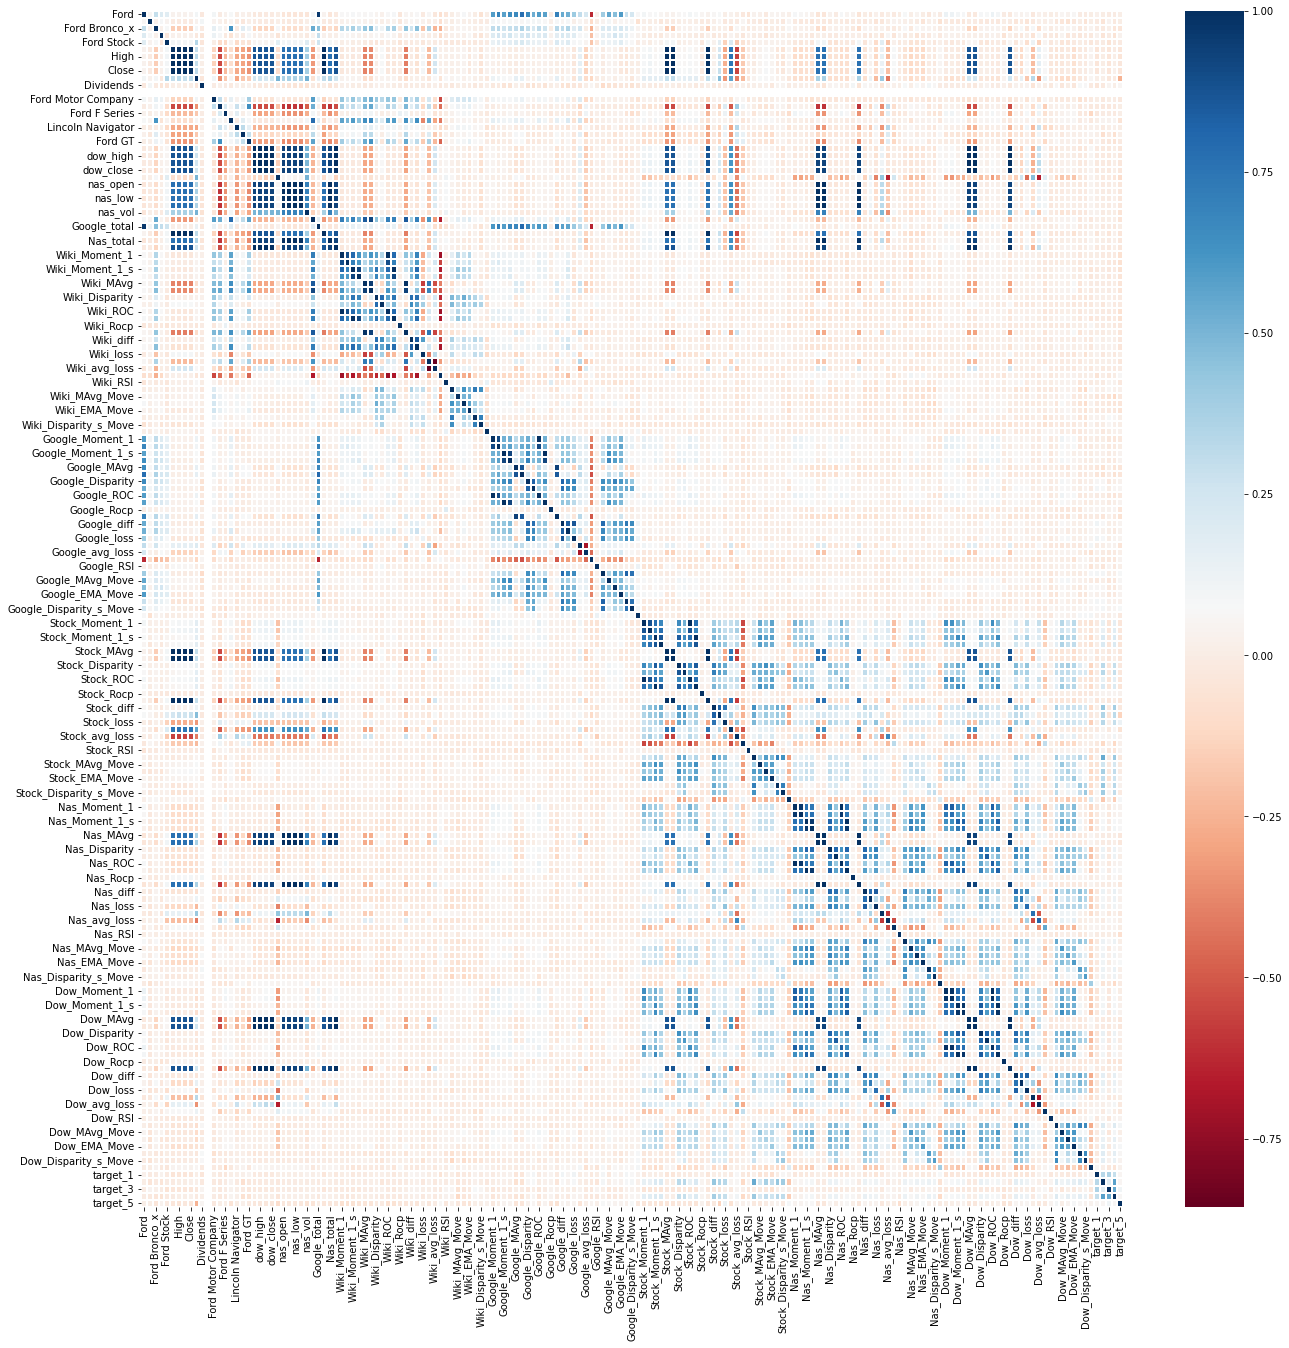

In [88]:
plt.figure(figsize=(22, 22))
sns.heatmap(
    Ford.corr(),
    linewidths=0.1,
    cmap='RdBu',
)

# Early Model Work 